<a href="https://colab.research.google.com/github/yoii18/KaggleModels/blob/main/Kaggle_PGS_S4E2_TetsuWay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install shap

In [4]:
!pip install colorama

In [5]:
!pip install catboost

In [6]:
!pip install category_encoders

In [7]:
!pip install optuna

In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, roc_curve
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
import seaborn as sns
from category_encoders import OneHotEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import shap

In [9]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2', '#fee08b',
           '#66c2a5', '#5e4fa2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

plt.style.use('fivethirtyeight')

 We have the following features in our dataframes

 1. Gender
 2. Age
 3. Height
 4. Weight
 5. Frequent consumption of high caloric food (FAVC)
 6. Frequency of consumption of vegetables (FCVC)
 7. Number of main meals (NCP)
 8. Consumption of food between meals (CAEC)
 9. Consumption of water daily (CH20)
 10. Consumption of alcohol (CALC)
 11. Calories consumption monitoring (SCC)
 12. Physical activity frequency (FAF)
 13. Time using technology devices (TUE)
 14. Transportation used (MTRANS)
 15. family_history_with_overweight
 16. SMOKE

<b> Target Variable: </b><br>
NObesity values are:<br>
<li> Underweight Less than 18.5 </li>
<li>    Normal 18.5 to 24.9 </li>
<li>   Overweight 25.0 to 29.9 </li>
<li>    Obesity I 30.0 to 34.9 </li>
<li>    Obesity II 35.0 to 39.9 </li>
<li>    Obesity III Higher than 40 </li>

In [10]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab_Data/Kaggle_PGS_S4E2/train.csv', index_col=[0])
test_data = pd.read_csv('/content/drive/MyDrive/Colab_Data/Kaggle_PGS_S4E2/test.csv', index_col=[0])
original_data = pd.read_csv('/content/drive/MyDrive/Colab_Data/Kaggle_PGS_S4E2/ObesityDataSet.csv')

#train_data['is_generated'] = 1
#test_data['is_generated'] = 1
#original_data['is_generated'] = 0

original_data = original_data.reset_index()
original_data['id'] = original_data['index'] + test_data.index[-1] + 1
original_data = original_data.drop(columns = ['index']).set_index('id')

target = 'NObeyesdad'

In [11]:
train_data.head(3)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight


In [12]:
def stats(df):
  desc = df.describe().T.style.background_gradient()
  display(desc)
  #return desc

In [13]:
stats(train_data)

,count,mean,std,min,25%,50%,75%,max
Age,20758.000000,23.841804,5.688072,14.000000,20.000000,22.815416,26.000000,61.000000
Height,20758.000000,1.700245,0.087312,1.450000,1.631856,1.700000,1.762887,1.975663
Weight,20758.000000,87.887768,26.379443,39.000000,66.000000,84.064875,111.600553,165.057269
FCVC,20758.000000,2.445908,0.533218,1.000000,2.000000,2.393837,3.000000,3.000000
NCP,20758.000000,2.761332,0.705375,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,20758.000000,2.029418,0.608467,1.000000,1.792022,2.000000,2.549617,3.000000
FAF,20758.000000,0.981747,0.838302,0.000000,0.008013,1.000000,1.587406,3.000000
TUE,20758.000000,0.616756,0.602113,0.000000,0.000000,0.573887,1.000000,2.000000


In [14]:
stats_test = stats(test_data)

,count,mean,std,min,25%,50%,75%,max
Age,13840.000000,23.952740,5.799814,14.000000,20.000000,22.906342,26.000000,61.000000
Height,13840.000000,1.698934,0.088761,1.450000,1.631662,1.700000,1.760710,1.980000
Weight,13840.000000,87.384504,26.111819,39.000000,65.000000,83.952968,111.157811,165.057269
FCVC,13840.000000,2.442898,0.531606,1.000000,2.000000,2.358087,3.000000,3.000000
NCP,13840.000000,2.750610,0.710927,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,13840.000000,2.032044,0.611230,1.000000,1.771781,2.000000,2.552388,3.000000
FAF,13840.000000,0.974532,0.840361,0.000000,0.001086,1.000000,1.571865,3.000000
TUE,13840.000000,0.611033,0.608005,0.000000,0.000000,0.552498,1.000000,2.000000


In [15]:
stats_original = stats(original_data)

,count,mean,std,min,25%,50%,75%,max
Age,2111.000000,24.312600,6.345968,14.000000,19.947192,22.777890,26.000000,61.000000
Height,2111.000000,1.701677,0.093305,1.450000,1.630000,1.700499,1.768464,1.980000
Weight,2111.000000,86.586058,26.191172,39.000000,65.473343,83.000000,107.430682,173.000000
FCVC,2111.000000,2.419043,0.533927,1.000000,2.000000,2.385502,3.000000,3.000000
NCP,2111.000000,2.685628,0.778039,1.000000,2.658738,3.000000,3.000000,4.000000
CH2O,2111.000000,2.008011,0.612953,1.000000,1.584812,2.000000,2.477420,3.000000
FAF,2111.000000,1.010298,0.850592,0.000000,0.124505,1.000000,1.666678,3.000000
TUE,2111.000000,0.657866,0.608927,0.000000,0.000000,0.625350,1.000000,2.000000


In [16]:
def unique_vals(df, title=None):
  columns = train_data.columns[0:-1]
  for cols in columns:
    print(f"{title} values in {cols} is: ", df[cols].nunique())

def null_vals(df, title=None):
  columns = train_data.columns[0:-1]
  for cols in columns:
    print(f"{title} values in {cols} is: ", df[cols].isnull().sum())

def duplicate_vals(df, title=None):
  columns = train_data.columns[0:-1]
  for cols in columns:
    print(f"{title} values in {cols} is: ", df.shape[0] - df[cols].duplicated().sum())

In [17]:
unique_vals(train_data, "unique")

unique values in Gender is:  2
unique values in Age is:  1703
unique values in Height is:  1833
unique values in Weight is:  1979
unique values in family_history_with_overweight is:  2
unique values in FAVC is:  2
unique values in FCVC is:  934
unique values in NCP is:  689
unique values in CAEC is:  4
unique values in SMOKE is:  2
unique values in CH2O is:  1506
unique values in SCC is:  2
unique values in FAF is:  1360
unique values in TUE is:  1297
unique values in CALC is:  3
unique values in MTRANS is:  5


In [18]:
unique_vals(original_data, "unique")

unique values in Gender is:  2
unique values in Age is:  1402
unique values in Height is:  1574
unique values in Weight is:  1525
unique values in family_history_with_overweight is:  2
unique values in FAVC is:  2
unique values in FCVC is:  810
unique values in NCP is:  635
unique values in CAEC is:  4
unique values in SMOKE is:  2
unique values in CH2O is:  1268
unique values in SCC is:  2
unique values in FAF is:  1190
unique values in TUE is:  1129
unique values in CALC is:  4
unique values in MTRANS is:  5


In [19]:
null_vals(train_data, "null")

null values in Gender is:  0
null values in Age is:  0
null values in Height is:  0
null values in Weight is:  0
null values in family_history_with_overweight is:  0
null values in FAVC is:  0
null values in FCVC is:  0
null values in NCP is:  0
null values in CAEC is:  0
null values in SMOKE is:  0
null values in CH2O is:  0
null values in SCC is:  0
null values in FAF is:  0
null values in TUE is:  0
null values in CALC is:  0
null values in MTRANS is:  0


In [20]:
null_vals(original_data, "null")

null values in Gender is:  0
null values in Age is:  0
null values in Height is:  0
null values in Weight is:  0
null values in family_history_with_overweight is:  0
null values in FAVC is:  0
null values in FCVC is:  0
null values in NCP is:  0
null values in CAEC is:  0
null values in SMOKE is:  0
null values in CH2O is:  0
null values in SCC is:  0
null values in FAF is:  0
null values in TUE is:  0
null values in CALC is:  0
null values in MTRANS is:  0


In [21]:
duplicate_vals(train_data, "duplicate")

duplicate values in Gender is:  2
duplicate values in Age is:  1703
duplicate values in Height is:  1833
duplicate values in Weight is:  1979
duplicate values in family_history_with_overweight is:  2
duplicate values in FAVC is:  2
duplicate values in FCVC is:  934
duplicate values in NCP is:  689
duplicate values in CAEC is:  4
duplicate values in SMOKE is:  2
duplicate values in CH2O is:  1506
duplicate values in SCC is:  2
duplicate values in FAF is:  1360
duplicate values in TUE is:  1297
duplicate values in CALC is:  3
duplicate values in MTRANS is:  5


In [22]:
duplicate_vals(original_data, "duplicate")

duplicate values in Gender is:  2
duplicate values in Age is:  1402
duplicate values in Height is:  1574
duplicate values in Weight is:  1525
duplicate values in family_history_with_overweight is:  2
duplicate values in FAVC is:  2
duplicate values in FCVC is:  810
duplicate values in NCP is:  635
duplicate values in CAEC is:  4
duplicate values in SMOKE is:  2
duplicate values in CH2O is:  1268
duplicate values in SCC is:  2
duplicate values in FAF is:  1190
duplicate values in TUE is:  1129
duplicate values in CALC is:  4
duplicate values in MTRANS is:  5


In [23]:
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)
print("Original Data Shape: ", original_data.shape)

Train Data Shape:  (20758, 17)
Test Data Shape:  (13840, 16)
Original Data Shape:  (2111, 17)


<b>Important points to look at from above stats:</b>
<br>
1. On the surface, there are no null values in our dataset
2. But, We see that `FAF` and `TUE` have values 0 which is not possible (in my opinion) so we must treat them as null values and impute them with mean values, since both these features are continuous features.
3. We have quite a lot of duplicate values in Original Data, while they shouldn't matter much in our train dataset, since the difference in number of duplicates in train and number of observations in train is huge, I feel that original dataset is not good enough to use since most values are duplicates

# Data Encoding and Feature Engineering
In this section we will do the following:
1. Impute values in `FAF` and `TUE`
2. Encode the dataset
    * We will do `OneHotEncoding` on all categorical features except our `target`
    * On `target` we will do Label Encoding

3. We will then do Adversarial Validation to see if our Train-Test data is iid or not


In [24]:
train_data.head(2)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.66995,yes,yes,2.0,2.983297,Sometimes,no,2.763573,no,0.0,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.00000,yes,yes,2.0,3.000000,Frequently,no,2.000000,no,1.0,1.000000,no,Automobile,Normal_Weight


In [25]:
#train_data = train_data.copy(deep=True)
train_data[['FAF','TUE']] = train_data[['FAF','TUE']].replace(0,np.nan)

null_vals(train_data, 'null')

null values in Gender is:  0
null values in Age is:  0
null values in Height is:  0
null values in Weight is:  0
null values in family_history_with_overweight is:  0
null values in FAVC is:  0
null values in FCVC is:  0
null values in NCP is:  0
null values in CAEC is:  0
null values in SMOKE is:  0
null values in CH2O is:  0
null values in SCC is:  0
null values in FAF is:  5044
null values in TUE is:  6566
null values in CALC is:  0
null values in MTRANS is:  0


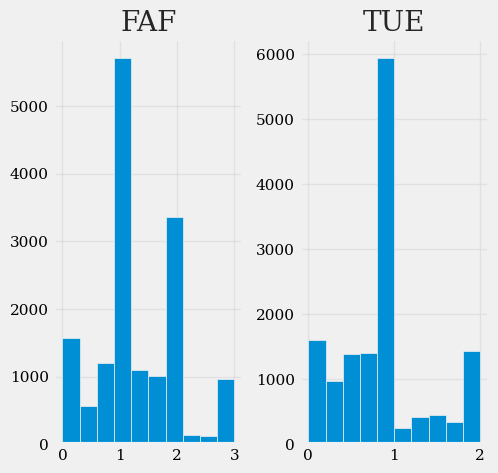

In [26]:
plot = train_data[['FAF', 'TUE']].hist(figsize=(5,5))

In [27]:
train_data['FAF'].fillna(train_data['FAF'].mean(), inplace=True)
train_data['TUE'].fillna(train_data['TUE'].mean(), inplace=True)

null_vals(train_data, 'null')

null values in Gender is:  0
null values in Age is:  0
null values in Height is:  0
null values in Weight is:  0
null values in family_history_with_overweight is:  0
null values in FAVC is:  0
null values in FCVC is:  0
null values in NCP is:  0
null values in CAEC is:  0
null values in SMOKE is:  0
null values in CH2O is:  0
null values in SCC is:  0
null values in FAF is:  0
null values in TUE is:  0
null values in CALC is:  0
null values in MTRANS is:  0


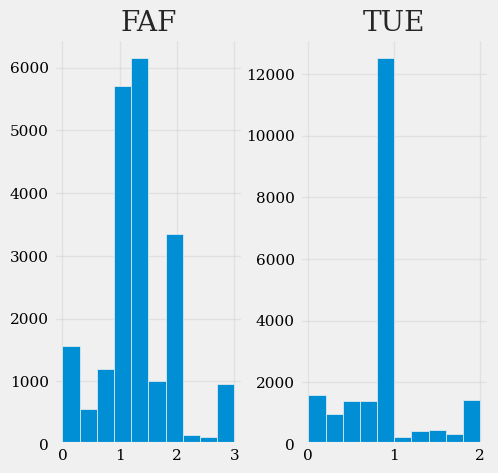

In [28]:
plot = train_data[['FAF', 'TUE']].hist(figsize=(5,5))

In [29]:
cat_cols, num_cols = [], []
columns = train_data.columns.tolist()
threshold = 5
for col in columns:
  if train_data[col].nunique() <= threshold:
    cat_cols.append(col)
  else:
    num_cols.append(col)

In [30]:
num_cols.remove(target)
num_cols

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [31]:
categories = ['Normal_Weight',
              'Insufficient_Weight',
              'Overweight_Level_I',
              'Overweight_Level_II',
              'Obesity_Type_I',
              'Obesity_Type_II',
              'Obesity_Type_III']

In [32]:
ce_ohe = OneHotEncoder(cols=cat_cols)
train_encoded = ce_ohe.fit_transform(train_data, train_data[target])
test_encoded = ce_ohe.fit_transform(test_data)
#original_encoded = ce_ohe.fit_transform(original_data, original_data[target])

ce_le = LabelEncoder()
train_encoded[target] = ce_le.fit_transform(train_encoded[target])
#test_encoded_data = ce_oe.fit_transform(train_encoded, train_encoded[target])
#original_encoded[target] = ce_le.fit_transform(original_encoded[target])

### Why Adversarial Validation?
We use it to see if our train and test data are actually iid or not, so a higher roc-auc score would mean that our model is able to distinguish between test and train data very easily, we don't want that.

<b> why? </b><br>
Because if train and test data is easily distinguishable, our model will not work properly, there would be space that are not present in train data but they are present in test data, so our model wouldn't generalize properly.
<br>
We want our datasets to be indistinguishable so that the model we ultimately train generalizes properly


Now, I have a function where I do adversarial validation and I remove the most important features according to this model.
<br> <b> why? </b>
<br>
Because these are the features that make our train and test data distinguishable so removing these features should make our data slightly more indistinguishable.


##### <b>NOTE: Removing a lot of features might result in accuracy of model later on </b>

In [33]:
def adversarial_validation(dataset_1 = train_encoded, dataset_2 = test_encoded, label = 'Train-Test'):

    adv_train = dataset_1.drop(target, axis = 1)
    adv_test = dataset_2.copy()

    adv_train['is_test'] = 0
    adv_test['is_test'] = 1

    adv = pd.concat([adv_train, adv_test], ignore_index = True)

    adv_shuffled = adv.sample(frac = 1)

    adv_X = adv_shuffled.drop('is_test', axis = 1)
    adv_y = adv_shuffled.is_test

    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

    val_scores = []
    predictions = np.zeros(len(adv))

    for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):

        adv_lr = xgb.XGBClassifier(random_state = 42)
        adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])

        val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:,1]
        predictions[val_idx] = val_preds
        val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
        val_scores.append(val_score)

    fpr, tpr, _ = roc_curve(adv['is_test'], predictions)

    plt.figure(figsize = (4, 4))
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
    sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
    plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight = 'bold', size = 17)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    importance = adv_lr.feature_importances_  #(adv_shuffled, type='ShapValues')
    plt.barh(adv_X.columns.tolist(), importance)

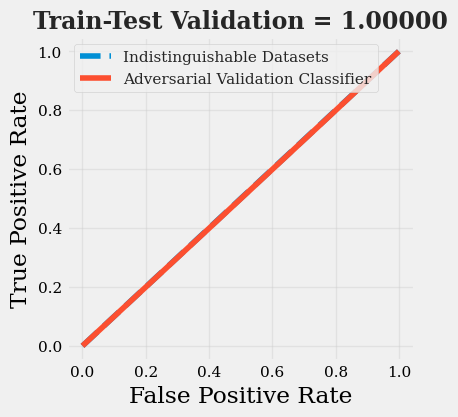

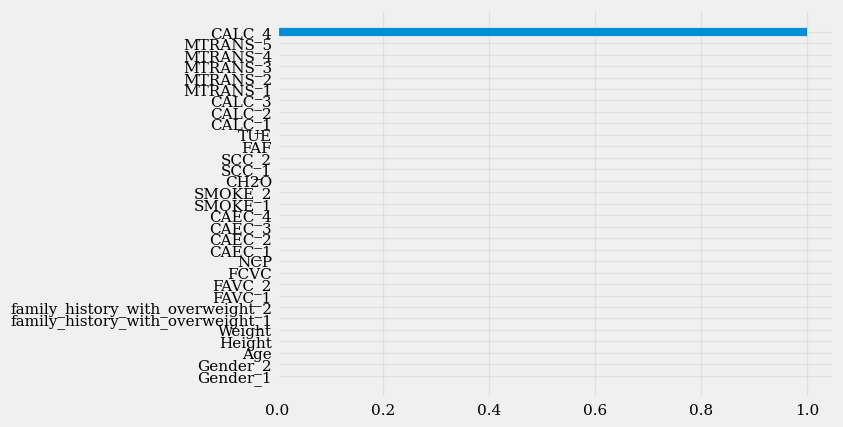

In [34]:
adversarial_validation()

In [35]:
test_encoded.drop('CALC_4', axis=1, inplace=True)
test_encoded.shape

(13840, 30)

In [ ]:
adversarial_validation()

In [ ]:
test_encoded.drop(['CAEC_1', 'CAEC_2', 'CAEC_3', 'TUE', 'FAF'], axis=1, inplace=True)
train_encoded.drop(['CAEC_1', 'CAEC_2', 'CAEC_3', 'TUE', 'FAF'], axis=1, inplace=True)
print(test_encoded.shape)
print(train_encoded.shape)

In [ ]:
adversarial_validation()

# Exploratory Data Analysis
<b>Analysis of Target Variable</b>
<br>
From our plots we can see that the data distribustion is even between various classes which is good

In [ ]:
def target_var(df, title=None):
  fig, axes = plt.subplots(1,2,figsize=(9,3))
  sns.set(font_scale=0.6)
  df[target].value_counts().plot.pie(autopct='%1.1f%%',
                                    wedgeprops={'width': 0.5},
                                    startangle=0,
                                    ax=axes[0],
                                    shadow=False,
                                    textprops={'fontsize': 9},
                                    colors=palette)
  axes[0].set_ylabel('')
  sns.countplot(x=target, data=df, palette=palette)
  plt.suptitle(f"{title} - Target Variable Analysis")
  plt.tight_layout()
  plt.show()

In [ ]:
target_var(train_encoded, 'Train Data')

In [ ]:
n_cols = 4
n_rows = 2

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))

for i, var_name in enumerate(num_cols):
    if var_name != target:
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.histplot(train_data[var_name], kde=True, ax=ax, label='Train')
        sns.histplot(test_data[var_name], kde=True, ax=ax, label='Test')
        #sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
n_cols = 4
n_rows = 2

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))

for i, var_name in enumerate(cat_cols):
    if var_name != target:
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.countplot(train_data[var_name], ax=ax, label='Train')
        sns.countplot(test_data[var_name], ax=ax, label='Test')
        #sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()

plt.tight_layout()
plt.show()

<b> Correlation Plot </b>

In [ ]:
corr = train_encoded.corr()
mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(15,15))
sns.set(font_scale=0.6)
sns.heatmap(corr, mask=mask, annot=True, cmap='BuPu')

# Modelling

In [ ]:
X = train_encoded.drop([f'{target}'],axis=1).reset_index(drop=True)
y = train_encoded[f'{target}'].reset_index(drop=True)
X_test = test_encoded.reset_index(drop=True)

In [ ]:
num_cols.remove('FAF')
num_cols.remove('TUE')
num_cols

In [ ]:
X.head()

In [ ]:
sc = StandardScaler()
X[num_cols] = sc.fit_transform(X[num_cols])
X_test[num_cols] = sc.transform(X_test[num_cols])

In [ ]:
X.head()

In [ ]:
print(f"X_train shape :{X.shape} , y_train shape :{y.shape}")
print(f"X_test shape :{X_test.shape}")

In [ ]:
X_train = X.copy(deep=True)
y_train = y.copy(deep=True)

In [ ]:
class Splitter:
    def __init__(self, kfold=True, n_splits=5):
        self.n_splits = n_splits
        self.kfold = kfold

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
        else:
            raise ValueError(f"Invalid kfold: Must be True")

class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.len_models = len(self.models)

    def _define_model(self):

        xgb_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.05,
            'max_depth': 4,
            'subsample': 0.8,
            'colsample_bytree': 0.1,
            'n_jobs': -1,
            'eval_metric': 'mlogloss',
            'objective': 'multi:softprob',
            'tree_method': 'hist',
            'verbosity': 2,
            'random_state': self.random_state,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'

        lgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 7,
            'learning_rate': 0.05,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'device': self.device,
            'verbosity': -1,
            'random_state': self.random_state
        }

        cb_params = {
            'iterations': self.n_estimators,
            'depth': 7,
            'learning_rate': 0.1,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'MultiClass',
            'loss_function': 'MultiClass',
            'task_type': self.device.upper(),
            'random_state': self.random_state
        }

        models = {
            'svc': SVC(gamma="auto", probability=True, random_state=self.random_state),
            #'xgb': xgb.XGBClassifier(**xgb_params),
            'lgb': lgb.LGBMClassifier(**lgb_params),
            'cat': CatBoostClassifier(**cb_params),
            'brf': BalancedRandomForestClassifier(n_estimators=4000, n_jobs=-1, random_state=self.random_state),
            'rf': RandomForestClassifier(n_estimators=1000, random_state=self.random_state),
        }

        return models

In [ ]:
!pip install cmaes

In [ ]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=2000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 1e-12, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=weights)

        # Calculate the MAP@3 score for the weighted prediction
        top_preds = np.argsort(-weighted_pred, axis=1)[:, :3]
        score = mapk(y_true.reshape(-1, 1), top_preds, 3)

        return score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        self.study = optuna.create_study(sampler=sampler, study_name="OptunaWeights", direction='maximize') # minimize
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)

    def weights(self):
        return self.weights

def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [ ]:
!pip install umap

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set the default color palette to "pastel"
sns.set_palette("muted")
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF
import umap
from sklearn.manifold import TSNE

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
kfold = True
n_splits = 1 if not kfold else 5 # 15
random_state = 8741
random_state_list = [70669, 26564, 12642] # used by split_data [70669, 26564]
n_estimators = 9999 # 9999
early_stopping_rounds = 200
verbose = False
device = 'cpu'
atk = 3
splitter = Splitter(kfold=kfold, n_splits=n_splits)

# Initialize an array for storing test predictions
test_predss = np.zeros((X_test.shape[0], len(y_train.unique())))
ensemble_score = []
ensemble_mapk_score = []
weights = []
trained_models = {'xgb':[], 'lgb':[], 'cat':[], 'rf':[]}
#rank_df = pd.DataFrame(columns=swapped_map.keys(), index=X_test.index).fillna(0)


for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits

    # Get a set of Regressor models
    classifier = Classifier(n_estimators, device, random_state)
    models = classifier.models

    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []

    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        if name in ['xgb', 'cat']:
            model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        else:
            model.fit(X_train_, y_train_)

        if name in trained_models.keys():
            trained_models[f'{name}'].append(deepcopy(model))

        test_pred = model.predict_proba(X_test)
        y_val_pred = model.predict_proba(X_val)

        top_preds = np.argsort(-y_val_pred, axis=1)[:, :atk]
        mapk_score = mapk(y_val.values.reshape(-1, 1), top_preds, atk)

        score = log_loss(y_val, y_val_pred)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] MAP@{atk}: {mapk_score:.5f}, Logloss: {score:.5f}')

        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)

    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)

    score = log_loss(y_val, y_val_pred)
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] MAP@{atk}: {mapk_score:.5f}, Logloss: {score:.5f}')
    ensemble_score.append(score)
    ensemble_mapk_score.append(mapk_score)
    weights.append(optweights.weights)

    # Predict to X_test by the best ensemble weights
    _test_preds = optweights.predict(test_preds)
    test_predss += _test_preds / (n_splits * len(random_state_list))


    gc.collect()

In [ ]:
'''
  params = dict(use_label_encoder=False,
                  eval_metric='logloss',
                  objective='multi:softmax',
              verbosity=1,
              random_state=42)
  params = {'use_label_encoder': False,
 'eval_metric': 'logloss',
 'objective': 'multi:softmax',
 'verbosity': 1,
 'random_state': 42,
 'n_estimators': 868,
 'max_depth': 25,
 'learning_rate': 0.11905203649814056,
 'gamma': 0.6515083313645063,
 'subsample': 0.5781693112712974,
 'min_child_weight': 0.9985117520274043,
 'reg_lambda': 1.8351930568718644,
 'reg_alpha': 1.57763685768516,
 'colsample_bytree': 0.43475654245755296}
 #'tree_method': 'gpu_hist',
 #'gpu_id': 0})
#gpu_params = dict(tree_method='gpu_hist',gpu_id=0)
#params.update(gpu_params)
  params
'''

In [ ]:
'''
strat_split = StratifiedKFold(n_splits=5,
                              random_state=42,
                              shuffle = True)

model = xgb.XGBClassifier(**params)
lg_loss = []
for fold, (train_idx, test_idx) in enumerate(strat_split.split(X=X, y=y)):
    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]
    X_val = X.loc[test_idx]
    y_val = y.loc[test_idx]

    #model.fit(X_train, y_train,eval_set=[(X_val,y_val)], early_stopping_rounds=100)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)
    fold_lgloss = log_loss(y_val,preds)
    print(fold_lgloss)
    lg_loss.append(fold_lgloss)

print(f"Mean log_loss : {np.mean(lg_loss)}")
'''


In [ ]:
predictions = model.predict(X_test)

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/Colab_Data/Kaggle_PGS_S4E2/sample_submission.csv", index_col=None)

In [ ]:
submit = pd.DataFrame(predictions, columns = ['target'])
submit['id'] = submission['id']
submit = submit[['id','target']]
le_target_map = dict(zip(ce_le.transform(ce_le.classes_), ce_le.classes_))
le_target_map

In [ ]:
submit['NObeyesdad'] = submit['target'].apply(lambda x: le_target_map[x])
submit = submit[['id','NObeyesdad']]

In [ ]:
submit

In [ ]:
submit.to_csv("/content/drive/MyDrive/Colab_Data/Kaggle_PGS_S4E2/submission.csv", index=False)